In [1]:
from sklearn import cluster
from osgeo import gdal
import geopandas as gdp
import pandas as pd
import numpy as np
import rasterio as rio
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import os
import matplotlib.pyplot as plt
from glob import glob
from rasterio.plot import show
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree

In [2]:
# load in all videos    
dispids = ['LC08_L1TP_043035_20160823_20170223_01_T1_','LC08_L1TP_044035_20160830_20170221_01_T1_',
           'LC08_L1TP_090084_20191231_20200111_01_T1_','LC08_L1TP_090084_20191215_20191226_01_T1_',
           'LC08_L1TP_091083_20191206_20191217_01_T1_','LC08_L1TP_090086_20191231_20200111_01_T1_']
dispidstest = ['LC08_L1TP_090083_20191215_20191226_01_T1_','LC08_L1TP_044033_20181108_20181116_01_T1_',
               'LC08_L1TP_044032_20181108_20181116_01_T1_']
bandsused = ['B6','B7']
exttarg = 'BT'
path = './data/Images/'
exten = '.tif'

alltb = []
all6 = []
all7 = []

for ids in dispids:
    strt = path+ids+exttarg+exten
    datatarg = gdal.Open(strt)
    bandtarg = datatarg.GetRasterBand(1)
    imgtarg = bandtarg.ReadAsArray()
    alltb.append(imgtarg>0)

    str6 = path+ids+bandsused[0]+exten
    dataset6 = gdal.Open(str6)
    Band6 = dataset6.GetRasterBand(1)
    img6 = Band6.ReadAsArray()
    all6.append(img6)
    
    str7 = path+ids+bandsused[1]+exten
    dataset7 = gdal.Open(str7)
    Band7 = dataset7.GetRasterBand(1)
    img7 = Band7.ReadAsArray()
    all7.append(img7)
    
del strt, datatarg, bandtarg, imgtarg, dispids, str6, dataset6, Band6, img6, str7, dataset7, Band7, img7

In [3]:
# find max array length
max_len = max(len(item.reshape(-1,1)) for item in all6)
# concatenate inputs and reshape variables
allts = []
for arr in alltb:
    vec = arr.reshape(-1,1)
    if len(vec) < max_len:
        vec = np.append(vec,np.zeros((max_len - len(vec)),dtype=bool)) 
    else:
        vec = vec[:].transpose(1,0).reshape(len(vec),)
    allts.append(vec)
allts = np.stack(allts,axis=0)
allts = allts.reshape(len(allts)*len(allts[0]),)

all6s = []
for arr in all6:
    vec = arr.reshape(-1,1)
    if len(vec) < max_len:
        vec = np.append(vec,np.zeros((max_len - len(vec)))) 
    else:
        vec = vec[:].transpose(1,0).reshape(len(vec),)
    all6s.append(vec)
all6s = np.stack(all6s,axis=0)
all6s = all6s.reshape(len(all6s)*len(all6s[0]),)

all7s = []
for arr in all7:
    vec = arr.reshape(-1,1)
    if len(vec) < max_len:
        vec = np.append(vec,np.zeros((max_len - len(vec)))) 
    else:
        vec = vec[:].transpose(1,0).reshape(len(vec),)
    all7s.append(vec)
all7s = np.stack(all7s,axis=0)
all7s = all7s.reshape(len(all7s)*len(all7s[0]),)

allin = np.stack([all6s,all7s])
print(allin)

del alltb, all6, all7, vec, all6s, all7s

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
allin = np.transpose(allin)
print(allin)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [5]:
# separate training and testing data
XTrain, XTest, yTrain, yTest = train_test_split(allin, allts, random_state=1, test_size=0.5)
decisionTree = tree.DecisionTreeClassifier()
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))


Accuracy on training data=  0.9999999576581603
Accuracy on test data=  0.9999964168218138


In [6]:
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

Accuracy on training data=  0.9999999576581603


In [7]:
del XTrain, XTest, yTrain, yTest, allin, allts, y_pred_train, y_pred

In [14]:
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

colorext = ['B2','B3','B4'] # blue, green, red in order

str2 = path+dispidstest[2]+colorext[0]+exten
dataset2 = gdal.Open(str2)
Band2 = dataset2.GetRasterBand(1)
img2 = Band2.ReadAsArray()

str3 = path+dispidstest[2]+colorext[1]+exten
dataset3 = gdal.Open(str3)
Band3 = dataset3.GetRasterBand(1)
img3 = Band3.ReadAsArray()

str4 = path+dispidstest[2]+colorext[2]+exten
dataset4 = gdal.Open(str4)
Band4 = dataset4.GetRasterBand(1)
img4 = Band4.ReadAsArray()

img2n = normalize(img2)
img3n = normalize(img3)
img4n = normalize(img4)
imgcolor = np.dstack((img2n, img3n, img4n))

str6 = path+dispidstest[2]+bandsused[0]+exten
dataset6 = gdal.Open(str6)
Band6 = dataset6.GetRasterBand(1)
img6 = Band6.ReadAsArray()
img6 = img6.reshape(-1,1)
    
str7 = path+dispidstest[2]+bandsused[1]+exten
dataset7 = gdal.Open(str7)
Band7 = dataset7.GetRasterBand(1)
img7 = Band7.ReadAsArray()
img7 = img7.reshape(-1,1)

img67 = np.stack([img6,img7])
img67 = np.transpose(img67)
img67 = img67.reshape(len(img6),2)

targ_pred = decisionTree.predict(img67)
targ_pred = targ_pred.reshape(np.shape(img2))

del img2, img3, img4, img6, img7, img67, str2, str3, str4, str6, str7, dataset2, dataset3, dataset4, dataset6, dataset7
del Band2, Band3, Band4, Band6, Band7

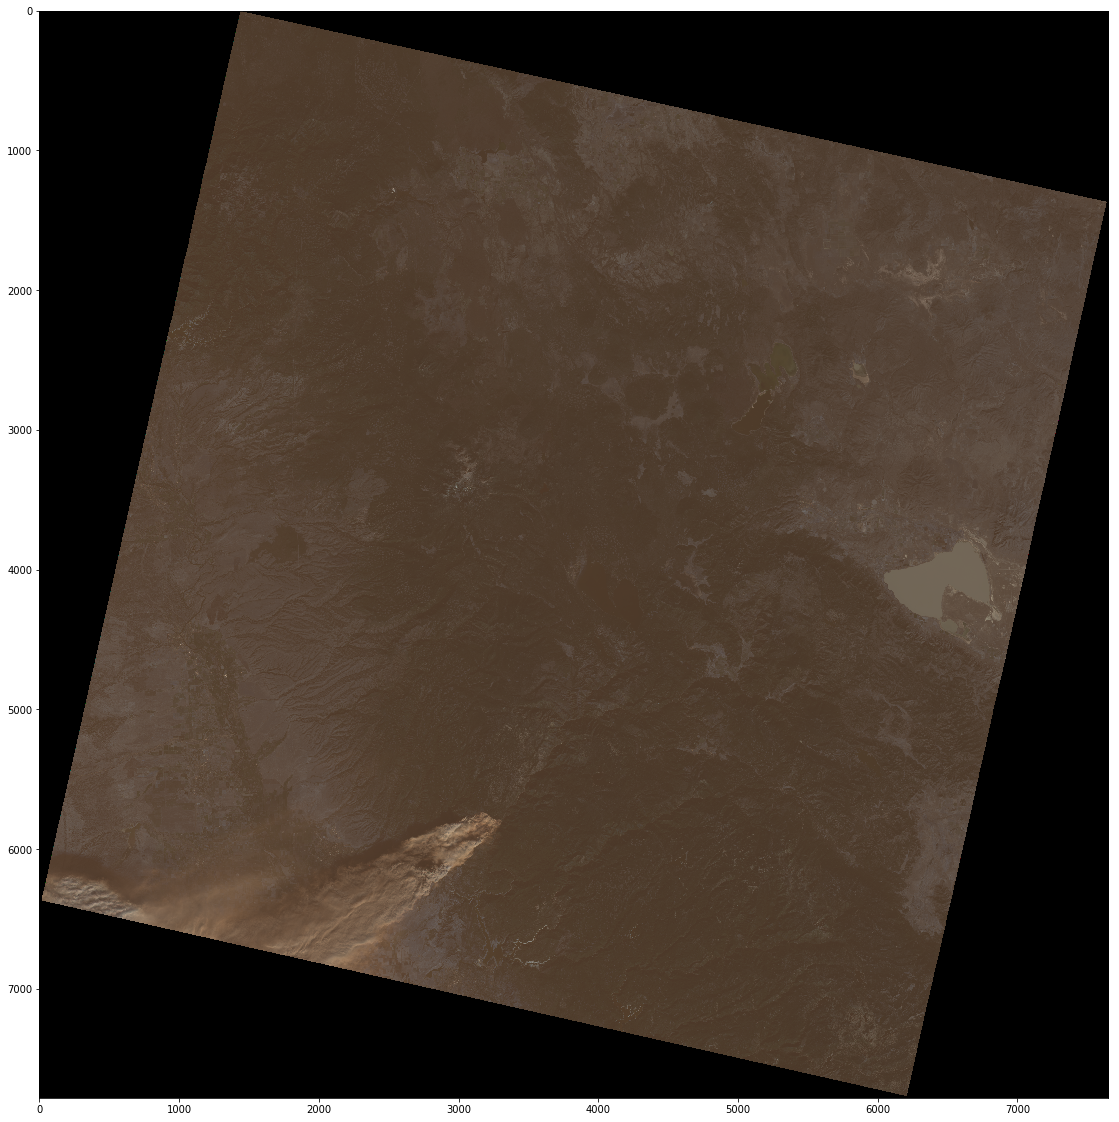

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(imgcolor)
plt.show()

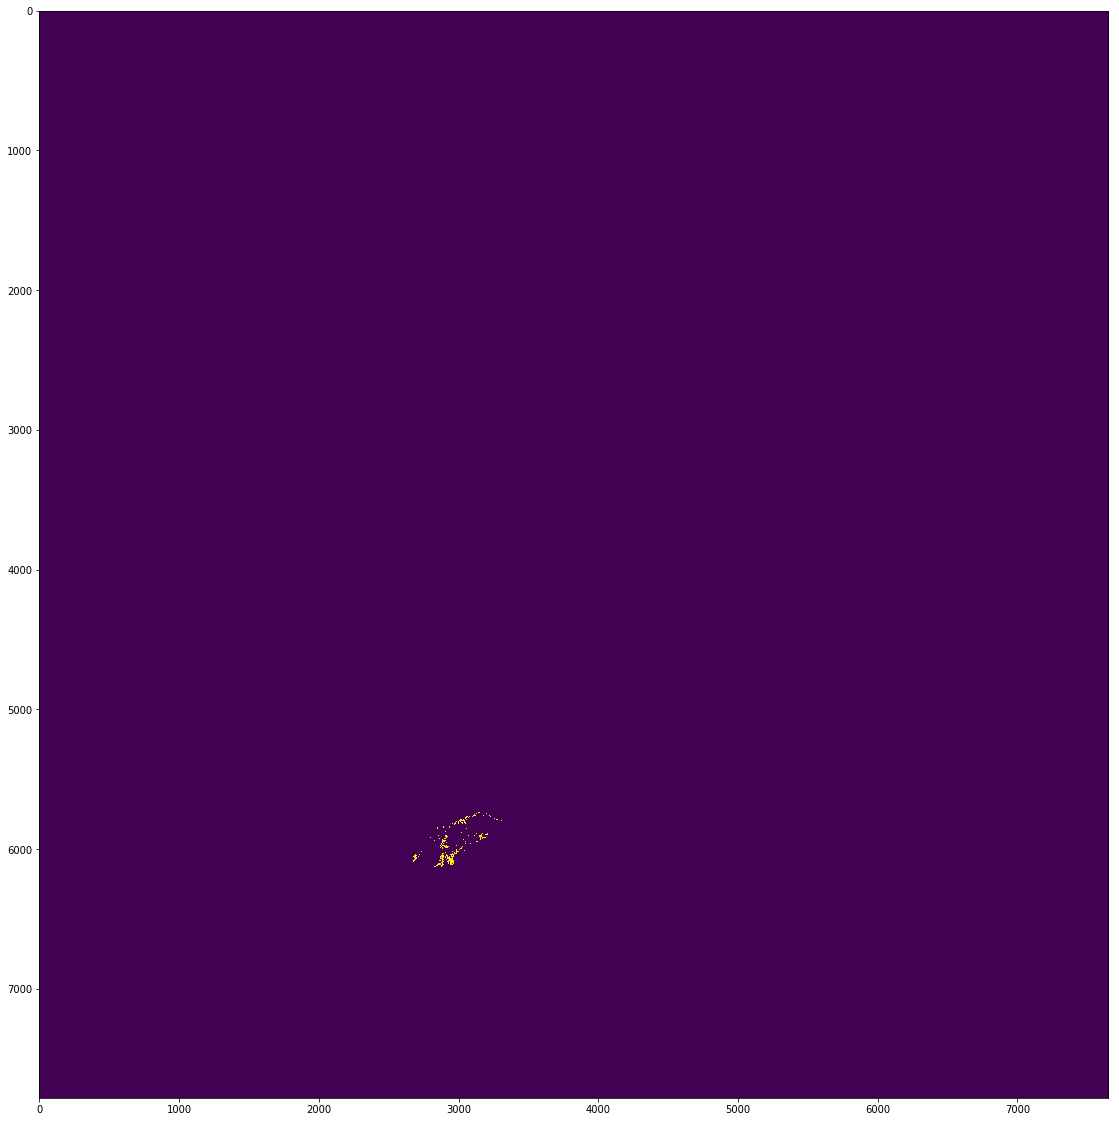

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(targ_pred)
plt.show()

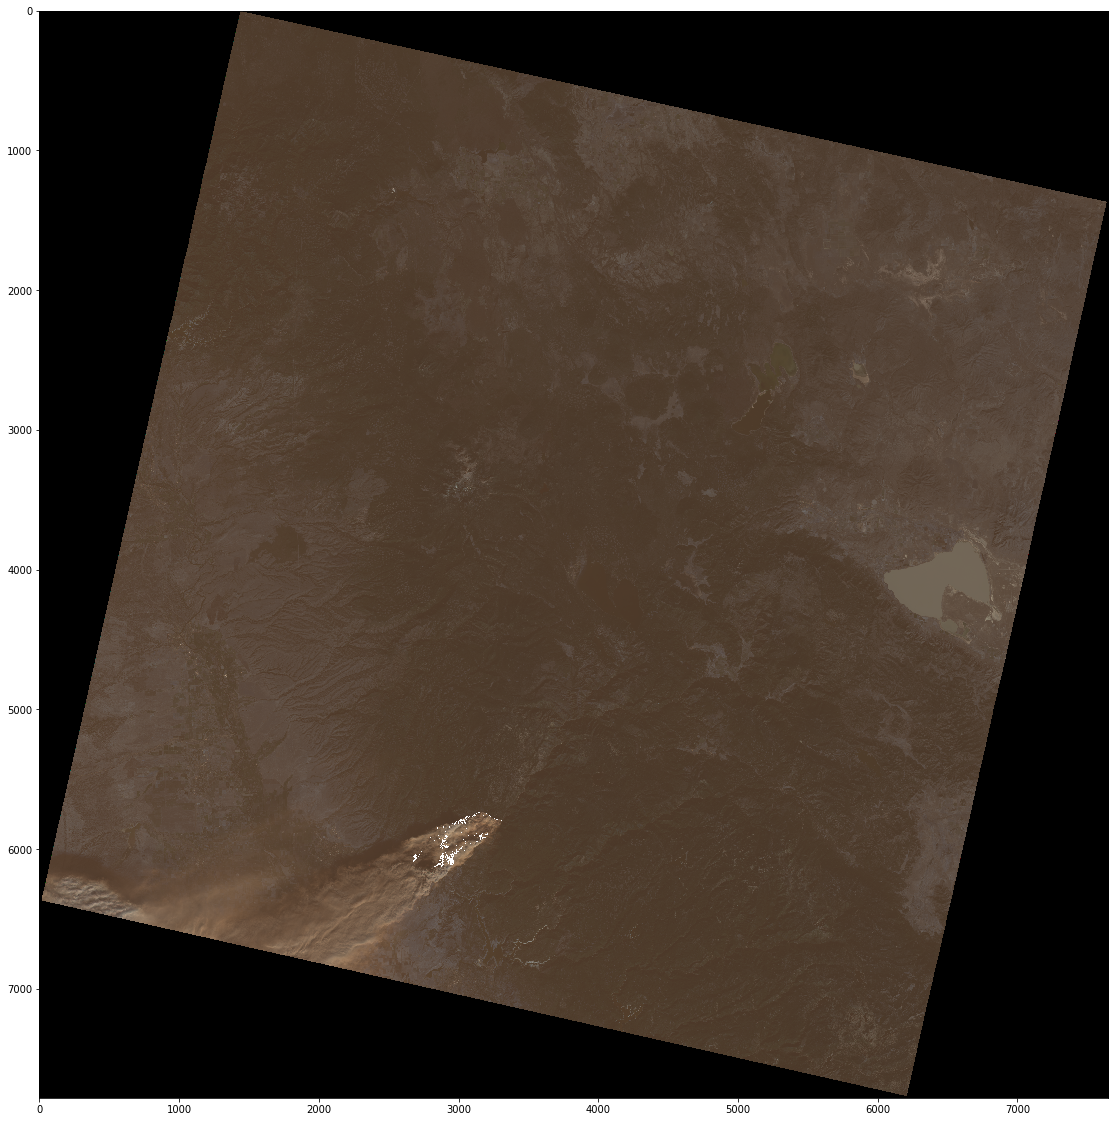

In [20]:
imgcolor[targ_pred] = 1
plt.figure(figsize=(20,20))
plt.imshow(imgcolor)
plt.show()